<a href="https://colab.research.google.com/github/aekaba/Customer-Churn-Prediction-with-AI/blob/main/CustomerChurnAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abonelik Sistemlerinde Müşteri Kaybı Analizi

## Dosya Okuma
  datasetimizi drive a kaydetip oradan okuma yapacağız, Train ve Test olarak 2 tane sınıfımız olduğu için bunları birleştireceğiz.

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import pandas as pd

# Read CSV files into dataframes
dfTesting = pd.read_csv('/content/drive/MyDrive/Customer Churn Dataset/customer_churn_dataset-testing-master.csv')
dfTraining = pd.read_csv('/content/drive/MyDrive/Customer Churn Dataset/customer_churn_dataset-training-master.csv')

mergedDF = pd.merge(dfTesting, dfTraining, how='outer')

df = pd.DataFrame(mergedDF)

<ipython-input-43-6df33b7f807d>:7: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  mergedDF = pd.merge(dfTesting, dfTraining, how='outer')


In [44]:
print("Toplam Satır Sayısı: ",len(df))
df.head()

Toplam Satır Sayısı:  505207


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1.0,22.0,Female,25.0,14.0,4.0,27.0,Basic,Monthly,598.0,9.0,1.0
1,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
2,2.0,41.0,Female,28.0,28.0,7.0,13.0,Standard,Monthly,584.0,20.0,0.0
3,3.0,47.0,Male,27.0,10.0,2.0,29.0,Premium,Annual,757.0,21.0,0.0
4,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0


##Veri Keşfi
Eksik verilerimizin ne kadar ve nerede olduğunu gördük. Veri Seti elemanlarının dağılımlarının eşit olduğunu gördük. Isı haritası ile veri setimizdeki değişkenlerin korelasyonlarını görselleştirdik. Modelin performansı için CustomerID sütunu silinecektir. Chrun ile doğru ilişkide olan support calls (0.52) ve payment delay (0.33) görülmüştür. Ters ilişkide ise total spend (-0.37) dikkat çekmiştir. Yaş arttıkça churn ihtimalide (0.19) artmaktadır ama bu düşük bir değer.


In [45]:
missing_values = df.isnull().sum()
print(missing_values)
df.info()

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505207 entries, 0 to 505206
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         505206 non-null  float64
 1   Age                505206 non-null  float64
 2   Gender             505206 non-null  object 
 3   Tenure             505206 non-null  float64
 4   Usage Frequency    505206 non-null  float64
 5   Support Calls      505206 non-null  float64
 6   Payment Delay      505206 non-null  float64
 7   Subscription Type  505206 non-null  object 
 8   Contract Length    505206 non-null  object 
 9   Total Spend        505206 non-null  float64
 10  Last In

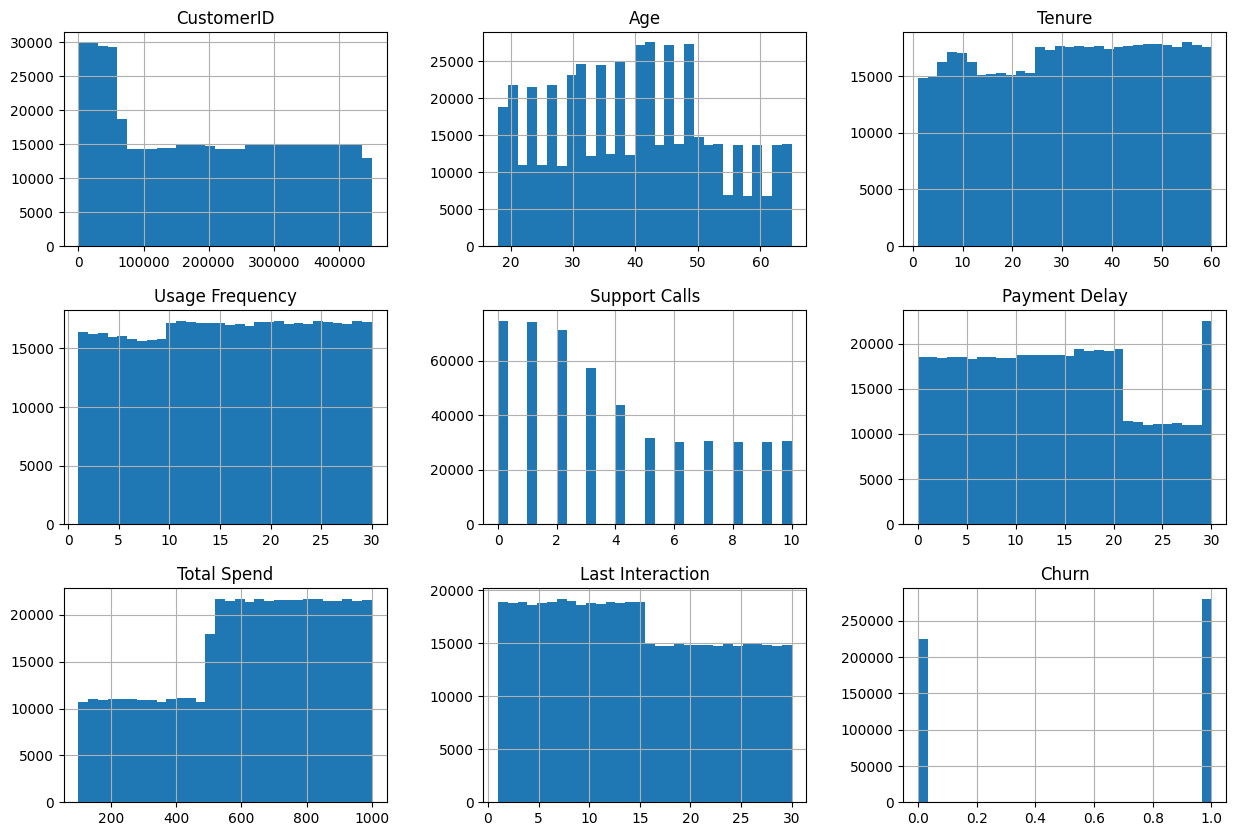

In [46]:
import matplotlib.pyplot as plt
df.hist(bins=30, figsize=(15, 10))
plt.show()

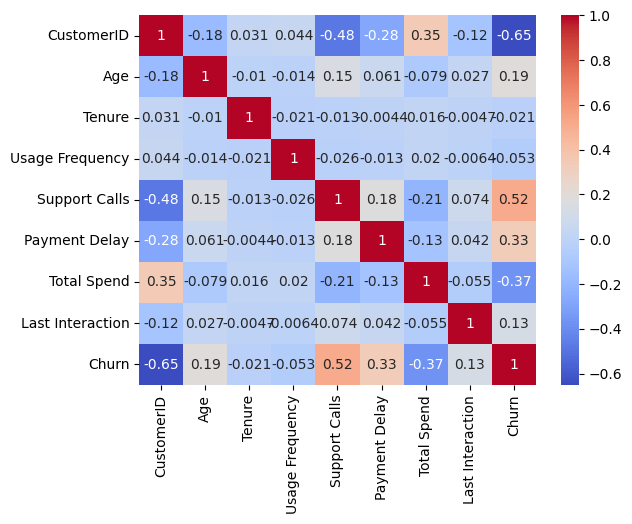

In [47]:
import seaborn as sns
numeric_df = df.select_dtypes(include=['number'])

# Calculate correlation matrix
corr_matrix = numeric_df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

##Veri Ön İşleme
Bu kısımda eksik veriler sütunun ortalaması ile doldurulacak, aykırı değerler z-skoru yöntemi ile tespit edilip temizlenecek. Gerekli sütunlar min-max scaler ile ölçeklemesi gerçekleştirilecek. ve customerID çıkarılacak. Veri ayırma işlemi %90 eğitim %10 test verisi olarak gerçekleştirilecektir.    


In [48]:
df=df.drop(columns=['CustomerID'])

### Eksik Verileri Doldurma
Burada sadedce int değerlerin ortalamasını girebileceğimiz için onları seçmemiz gerekir


In [49]:
import numpy as np
print("Eksik değerlerin sayısı:\n", df.isnull().sum())

numeric_df = df.select_dtypes(include=np.number)

df[numeric_df.columns] = df[numeric_df.columns].fillna(numeric_df.mean())
print("Eksik değerler dolduruldu.")

Eksik değerlerin sayısı:
 Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64
Eksik değerler dolduruldu.


Burada Gender, subscription type ve contract lenght bir integer değer olmadığı için onlarda eksik değer bulunan satırlar ortalaması farklı şekilde alınıp kullanıldı.

In [50]:
categorical_columns = ['Gender', 'Subscription Type', 'Contract Length']
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

<ipython-input-50-65c94d3875e3>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


### Aykırı verilerin Tespiti ve temizlenmesi
Z-Scoru Yöntemi ile aykırı veriler temizlenmiştir.

In [51]:
from scipy.stats import zscore

# Z-Skoru hesaplama
z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))
threshold = 2 # Aykırı değer eşiği
sd = df[(z_scores < threshold).all(axis=1)]
print(f"Aykırı değerler temizlendi. Yeni veri seti boyutu: {sd.shape}")

df_cleaned = sd


Aykırı değerler temizlendi. Yeni veri seti boyutu: (494576, 11)


Kategorik Verilerin Sayısal Hale Dönüştürülmesi
Burada Gender, Contract Lenght ve subscription Type Label encoding kullanılarak etikelenmiştir.

In [52]:
from sklearn.preprocessing import LabelEncoder

# Gender için Label Encoding
le_gender = LabelEncoder()
df_cleaned['Gender'] = le_gender.fit_transform(df_cleaned['Gender'])

# Contract Length için Label Encoding
le_contract = LabelEncoder()
df_cleaned['Contract Length'] = le_contract.fit_transform(df_cleaned['Contract Length'])

# Subscription Type için Label Encoding
le_subscription = LabelEncoder()
df_cleaned['Subscription Type'] = le_contract.fit_transform(df_cleaned['Subscription Type'])

print(df_cleaned.head())


<ipython-input-52-f8df42723aa8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Gender'] = le_gender.fit_transform(df_cleaned['Gender'])
<ipython-input-52-f8df42723aa8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Contract Length'] = le_contract.fit_transform(df_cleaned['Contract Length'])


    Age  Gender  Tenure  Usage Frequency  Support Calls  Payment Delay  \
0  22.0       0    25.0             14.0            4.0           27.0   
1  30.0       0    39.0             14.0            5.0           18.0   
2  41.0       0    28.0             28.0            7.0           13.0   
3  47.0       1    27.0             10.0            2.0           29.0   
4  65.0       0    49.0              1.0           10.0            8.0   

   Subscription Type  Contract Length  Total Spend  Last Interaction  Churn  
0                  0                1        598.0               9.0    1.0  
1                  2                0        932.0              17.0    1.0  
2                  2                1        584.0              20.0    0.0  
3                  1                0        757.0              21.0    0.0  
4                  0                1        557.0               6.0    1.0  


<ipython-input-52-f8df42723aa8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Subscription Type'] = le_contract.fit_transform(df_cleaned['Subscription Type'])


### Veri Ölçekleme
Min-Max Slacer kullanılarak yapılacaktır. Age, Usage Frequency, Support Calls, Payment Delay, Total Spend, Last Interaction, kısımlarına uygulanmıştır.

In [53]:
from sklearn.preprocessing import MinMaxScaler

numerical_columns = ['Age', 'Usage Frequency', 'Support Calls', 'Payment Delay',
                     'Total Spend', 'Last Interaction']
scaler = MinMaxScaler()

df_cleaned[numerical_columns] = scaler.fit_transform(df_cleaned[numerical_columns])

print(df_cleaned.head())


        Age  Gender  Tenure  Usage Frequency  Support Calls  Payment Delay  \
0  0.085106       0    25.0         0.448276            0.4       0.900000   
1  0.255319       0    39.0         0.448276            0.5       0.600000   
2  0.489362       0    28.0         0.931034            0.7       0.433333   
3  0.617021       1    27.0         0.310345            0.2       0.966667   
4  1.000000       0    49.0         0.000000            1.0       0.266667   

   Subscription Type  Contract Length  Total Spend  Last Interaction  Churn  
0                  0                1     0.538228          0.275862    1.0  
1                  2                0     0.921889          0.551724    1.0  
2                  2                1     0.522147          0.655172    0.0  
3                  1                0     0.720869          0.689655    0.0  
4                  0                1     0.491132          0.172414    1.0  


<ipython-input-53-5d64afb13069>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[numerical_columns] = scaler.fit_transform(df_cleaned[numerical_columns])


### Veri Ayırma
Burada verisetimiz işlenmiş olarak test ve eğitim verisi olarak 2 ayrı dataframe e ayrılacaktır. Başta %90 eğitim verisi %10 test verisi olarak ayrılacaktır. Eğer bu değerler yeterli olmazsa ileride değişiklik yapılacaktır.

In [54]:
from sklearn.model_selection import train_test_split

# Özellikler (X) ve hedef değişken (y) belirleme
X = df_cleaned.drop(columns=['Churn'])  # Churn hedef sütunu
y = df_cleaned['Churn']

# Veri setini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(f"Eğitim veri boyutu: {X_train.shape}, Test veri boyutu: {X_test.shape}")


Eğitim veri boyutu: (445118, 10), Test veri boyutu: (49458, 10)
